## 齊藤京子と守屋麗奈の分類

### データセット

In [55]:
# データセットとして画像を読み込み
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [56]:
# transform作成、テンソル化
transform=transforms.Compose([transforms.ToTensor()])

In [57]:
# img_dataから画像読み込み
path="./img_data/"
member_dataset=ImageFolder(path, transform)

print(len(member_dataset))
print(member_dataset.class_to_idx)

455
{'kyonko_face': 0, 'rena_face': 1}


### データローダー

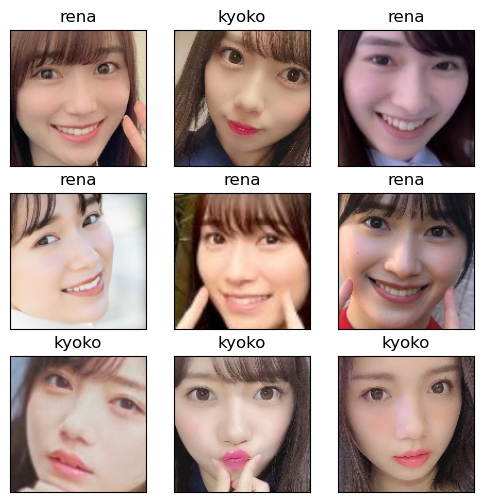

In [58]:
import matplotlib.pyplot as plt
import numpy as np

member_classes=np.array(['kyoko', 'rena'])
n_img=9

dataloader=DataLoader(member_dataset, batch_size=53, shuffle=True)
dataiter=iter(dataloader)
images, labels=next(dataiter)

plt.figure(figsize=(6,6))
for i in range(n_img):
    plt.subplot(3,3,i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))  # チャンネルを一番後ろに
    label=member_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

In [59]:
print(images[0].shape)

torch.Size([3, 128, 128])


### データの拡張

In [60]:
# アフィン変換
affine=transforms.RandomAffine(degrees=(-15,15), scale=(0.9,1.1))
# 左右反転
flip=transforms.RandomHorizontalFlip(1.0)
# ガウシアンフィルタ
gaussian=transforms.GaussianBlur(kernel_size=7)
# 正規化
norm=transforms.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0])

# 学習用
train_affine=transforms.Compose([affine, norm])
train_flip=transforms.Compose([flip, norm])
train_gaussian=transforms.Compose([gaussian, norm])
train_arg=transforms.Compose([affine, flip, gaussian, norm])

# 検証用
valid_norm=transforms.Compose([norm])

### 学習用データ水増し

In [61]:
from torch.utils.data import Subset, random_split
import torch
import random

class MySubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.indices)


# 学習データ、検証データに 8:2 の割合でデータセットを分割する。
train_size = int(0.8 * len(member_dataset))
valid_size=len(member_dataset)-train_size
# データの偏りをなくすための工夫としてインデックスをシャッフルする
indices=np.arange(len(member_dataset))
random.shuffle(indices)

#学習用データのオリジナル
train_dataset_original=Subset(member_dataset, indices[:train_size])
# 学習用データのアフィン変換
train_dataset_affine = MySubset(member_dataset, indices[:train_size], train_affine)
# 学習用データの左右反転
train_dataset_flip = MySubset(member_dataset, indices[:train_size], train_flip)
# 学習用データのガウシアンフィルタ
train_dataset_gaussian = MySubset(member_dataset, indices[:train_size], train_gaussian)
# 学習用データのアフィン変換+左右反転
train_dataset_arg = MySubset(member_dataset, indices[:train_size], train_arg)
# 学習用データ（オリジナル＋拡張）
train_dataset=train_dataset_original+train_dataset_affine+train_dataset_flip+train_dataset_gaussian+train_dataset_arg

# 検証用データ
valid_dataset = MySubset(member_dataset, indices[train_size:], valid_norm)


print(f"full: {len(member_dataset)}, train: {len(train_dataset)}, valid: {len(valid_dataset)}")

full: 455, train: 1820, valid: 91


In [62]:
#データローダ作成、学習用データはオリジナル＋拡張で水増し
batch_size=130
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader=DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)

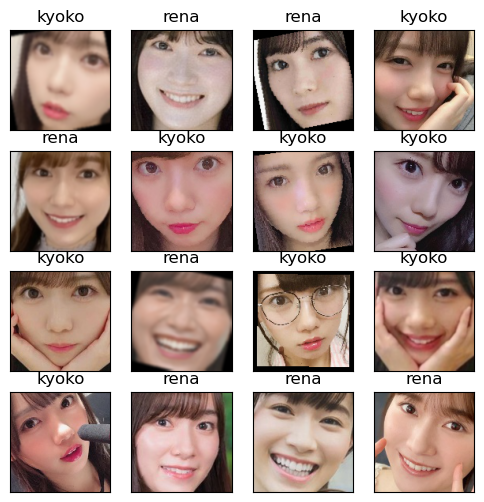

In [63]:
dataiter = iter(train_loader)  # イテレータ
images, labels = next(dataiter)  # 最初のバッチを取り出す

plt.figure(figsize=(6,6))  # 画像の表示サイズ
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))  # チャンネルを一番後ろに
    label=member_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

### アーキテクチャの定義

In [67]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,16,5) #畳み込み層：入力チャネル数、フィルタ数、フィルタサイズ
        self.pool=nn.MaxPool2d(2,2) #プーリング層：領域のサイズ、ストライド
        self.conv2=nn.Conv2d(16,16,5)
        self.fc1=nn.Linear(16*29*29, 256)
        self.dropout=nn.Dropout(0.5)
        self.fc2=nn.Linear(256,2)
        
    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))        
        x = x.view(-1, 16*29*29)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.softmax(x)
        return x

net=Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


### モデルの学習

In [68]:
from torch import optim
import time

#交差エントロピー損失
loss_function=nn.CrossEntropyLoss()
#最適化アルゴリズム
optimizer=optim.Adam(net.parameters())
#損失のログ
record_loss_train=[]
record_loss_valid=[]

#学習
x_valid, t_valid=next(iter(valid_loader))

for i in range(10):
    s=time.time()
    ###学習モード###
    net.train()
    loss_train=0
    for j, (x,t) in enumerate(train_loader):
        #順伝播
        y=net(x)
        #誤差の算出
        loss=loss_function(y, t)
        #誤差の加算
        loss_train+=loss.item()
        #勾配を0に初期化
        optimizer.zero_grad()
        #逆伝播
        loss.backward()
        #パラメータの更新
        optimizer.step()
    #1バッチあたりの平均の誤差
    loss_train=loss_train/(j+1)
    #record_loss_trainにappend
    record_loss_train.append(loss_train)
    ###検証モード###
    #順伝播による予測
    y_valid=net(x_valid)
    #誤差の算出
    loss_valid=loss_function(y_valid, t_valid)
    #record_loss_validにappend
    record_loss_valid.append(loss_valid)
    
    if i%1==0:
        print(f"Epoch {i}: Loss_train={loss_train}, Loss_valid={loss_valid}")

e=time.time()
print("学習時間：", e-s)

/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_42040/455380989.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch 0: Loss_train=0.6886505569730487, Loss_valid=0.6795185208320618
Epoch 1: Loss_train=0.6424901357718876, Loss_valid=0.6042687296867371
Epoch 2: Loss_train=0.5585175710065025, Loss_valid=0.5489131212234497
Epoch 3: Loss_train=0.5020466063703809, Loss_valid=0.49952441453933716
Epoch 4: Loss_train=0.46601904715810505, Loss_valid=0.5078510046005249
Epoch 5: Loss_train=0.4682782164641789, Loss_valid=0.4979499578475952
Epoch 6: Loss_train=0.445643955043384, Loss_valid=0.5158861875534058
Epoch 7: Loss_train=0.43739267332213266, Loss_valid=0.476543664932251
Epoch 8: Loss_train=0.4161910393408367, Loss_valid=0.48603808879852295
Epoch 9: Loss_train=0.4188827872276306, Loss_valid=0.45528915524482727
学習時間： 39.602540016174316


### 推論

In [69]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(valid_loader):
    print("正解：", t)
    y = net(x)
    print("予測：", y.argmax(1))
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解： tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0])
予測： tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0])
正解率: 83.51648351648352%


/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_42040/455380989.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [70]:
y

tensor([[1.0000e+00, 6.1957e-07],
        [1.0000e+00, 1.0839e-08],
        [1.3600e-01, 8.6400e-01],
        [5.7201e-01, 4.2799e-01],
        [9.9999e-01, 5.9947e-06],
        [1.0000e+00, 1.1671e-09],
        [1.3370e-04, 9.9987e-01],
        [9.9999e-01, 1.1473e-05],
        [1.1668e-01, 8.8332e-01],
        [1.9367e-01, 8.0633e-01],
        [1.0000e+00, 2.5491e-07],
        [6.2562e-05, 9.9994e-01],
        [9.1330e-01, 8.6704e-02],
        [9.8753e-01, 1.2469e-02],
        [9.5251e-01, 4.7488e-02],
        [6.4920e-01, 3.5080e-01],
        [9.7834e-01, 2.1664e-02],
        [9.9967e-01, 3.2927e-04],
        [8.4759e-03, 9.9152e-01],
        [1.0000e+00, 3.2676e-07],
        [1.0300e-01, 8.9700e-01],
        [9.5838e-01, 4.1621e-02],
        [9.9997e-01, 3.3194e-05],
        [9.9996e-01, 3.9160e-05],
        [9.9992e-01, 7.8977e-05],
        [9.9997e-01, 3.1885e-05],
        [4.8339e-04, 9.9952e-01],
        [2.6267e-02, 9.7373e-01],
        [4.5815e-02, 9.5418e-01],
        [9.637

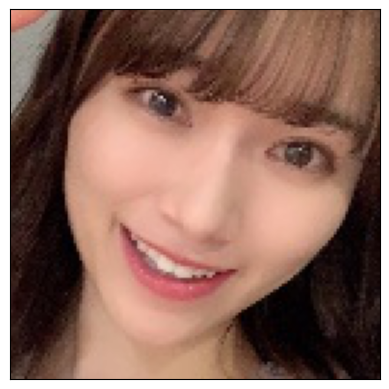

正解: rena 予測結果: rena


/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_42040/455380989.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [71]:
valid_loader1=DataLoader(valid_dataset, batch_size=1, shuffle=True)

dataiter = iter(valid_loader1)
images, labels = next(dataiter)  # サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

net.eval()  # 評価モード

x=images
y = net(x)

print("正解:", member_classes[labels[0]],"予測結果:", member_classes[y.argmax(1).item()])

### モデルの保存

In [72]:
#モデルの保存
import torch

path="./pytorch_kyokorena.pth"
torch.save(net.state_dict(),path)

In [73]:
# 読み込み
load_path = './pytorch_kyokorena.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)

<All keys matched successfully>